#### Calculate shear at locations of TC LMI from era5
addapted from James get_era5_shear_at_lmi.ncl <br>
Ming Ge June 2024

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

#### set up

In [2]:
lag = 2

#  averaging radius in degrees
rr = .5

#### read in lmi times/locations

In [3]:
flnm = '/glade/work/done/tc_int/Kossin_LMIs_cut.csv'
df_lmi = pd.read_csv(flnm, delimiter=',', engine='python')

yyyy = df_lmi.kyear.values 
mm   = df_lmi.kmon.values
dd   = df_lmi.kday.values
hh   = df_lmi.khour.values

yyyys = yyyy.astype(str)
mms   = mm.astype(str)
dds   = dd.astype(str)
hhs   = hh.astype(str)

ntim = len(hhs)

yyyymmddhh = [None] * ntim
for nt in range(ntim):
    current_date = datetime(yyyy[nt], mm[nt], dd[nt], hh[nt])
    
    # Calculate the date of the previous 2 days
    datetime_lagged = current_date - timedelta(days=lag)

    yyyys[nt] = str(datetime_lagged.year).zfill(2)
    mms[nt]   = str(datetime_lagged.month).zfill(2)
    dds[nt]   = str(datetime_lagged.day).zfill(2)
    hhs[nt]   = str(datetime_lagged.hour).zfill(2)
    yyyymmddhh[nt] = yyyys[nt] + mms[nt] + dds[nt] + hhs[nt] 

In [4]:
# E5 is on a quarter degree lat lon. Need to round to the nearest quarter to get the same dimensions for compositing.
lat = np.round(df_lmi.klat.values*4.0, 0)/4.0
lon = df_lmi.klon.values
lon = np.where(lon <= 0., lon+360., lon)
lon = np.round(lon*4.0, 0)/4.0 
vmax = df_lmi.lmi.values

#### Calculate wind shear from ERA5

In [ ]:
%%time
dir_era5 = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
#### note to safe time, I write 100 instead of all  TC LMI 
ntim = 100
shear = np.zeros((ntim))
for nt in range(ntim):
    dir = dir_era5 + yyyys[nt] + mms[nt] + "/" 
    flnm_u = dir + "e5.oper.an.pl.128_131_u.ll025uv." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
    print(nt, ntim, flnm_u)
    with xr.open_dataset(flnm_u) as ds_u:
        U200 = ds_u.U[hh[nt]].sel(level=200, latitude=slice(lat[nt]+rr, lat[nt]-rr), longitude=slice(lon[nt]-rr,lon[nt]+rr))
        U850 = ds_u.U[hh[nt]].sel(level=850, latitude=slice(lat[nt]+rr, lat[nt]-rr), longitude=slice(lon[nt]-rr,lon[nt]+rr))

    flnm_v = dir + "e5.oper.an.pl.128_132_v.ll025uv." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
    
    with xr.open_dataset(flnm_v) as ds_v:    
        V200 = ds_v.V[hh[nt]].sel(level=200, latitude=slice(lat[nt]+rr, lat[nt]-rr), longitude=slice(lon[nt]-rr,lon[nt]+rr))
        V850 = ds_v.V[hh[nt]].sel(level=850, latitude=slice(lat[nt]+rr, lat[nt]-rr), longitude=slice(lon[nt]-rr,lon[nt]+rr))

    shear[nt] = (np.sqrt(np.square(U200-U850) + np.square(V200-V850))).mean()

ds = xr.Dataset({'shear': (("time"), shear.astype(float))},
                 coords={"time": yyyymmddhh[:ntim]},
    attrs=dict(description="Vertical wind shear [[U200-U850]^2+[V200-V850]^2]^0.5", unit='m/s')
)    

dir_o = '/glade/derecho/scratch/mingge/ERA5/'
flnm_o = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius.nc"
print('output', flnm_o)
ds.to_netcdf(flnm_o)    


#### check results

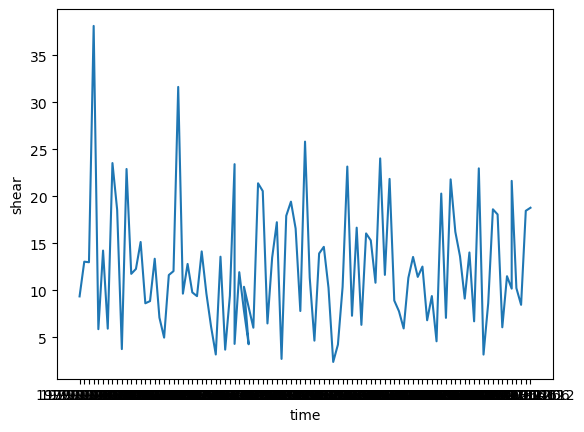

In [12]:
with xr.open_dataset(flnm_o) as ds_o:
    ds_o.shear.plot()

In [14]:
ds_o.shear.data

array([ 9.35303879, 13.05090618, 12.98942375, 38.14584351,  5.86399794,
       14.23150063,  5.91793823, 23.54749298, 18.57963943,  3.74462986,
       22.91702843, 11.75391388, 12.27822018, 15.1452322 ,  8.62131119,
        8.85228348, 13.3624239 ,  7.09553051,  4.96715736, 11.62742424,
       12.04391575, 31.65298653,  9.64698601, 12.80829144,  9.78055954,
        9.38085651, 14.14165115,  9.65951347,  6.12239075,  3.17018223,
       13.57978535,  3.6851542 ,  9.42076969, 23.42978096,  4.29597235,
       11.93177414,  7.82146072,  4.25910091, 10.37646484,  6.02183485,
       21.39483643, 20.56653023,  6.47513294, 13.47907352, 17.25056458,
        2.69900513, 17.93314934, 19.43942833, 16.57500267,  7.79765987,
       25.83116913, 11.34938812,  4.64283228, 13.92128181, 14.62882042,
       10.26036644,  2.3785789 ,  4.21437645, 10.36607265, 23.17540359,
        7.29198122, 16.67049026,  6.32461739, 16.05723953, 15.31483078,
       10.8082552 , 24.04151154, 11.64385509, 21.86220169,  8.91